# Pre-Processing & Modeling

### Pre-Processing

In [ ]:
# Imports
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import plot_model

# For reproducibility
np.random.seed(42)

In [ ]:
# Create a list for each food class
burgers_list = []
hotdogs_list = []
pizza_list = []
tacos_list = []
sushi_list = []

# Create a list of all food class lists
class_list = [burgers_list, hotdogs_list, pizza_list, tacos_list, sushi_list]

# Create a list of strings containing the food classes
food_classes = ['burgers', 'hotdogs', 'pizza', 'tacos', 'sushi']

In [ ]:
# Referenced: https://git.generalassemb.ly/DSIR-Lancelot/8.04-lesson-cnns/blob/master/solution-code/02-cnn.ipynb
# Define a function that converts all images
def image_converter(food_list, food_class):
    food_path = f'../images/{food_class}/'
    for file in os.listdir(food_path):
        try:
            image = load_img(food_path + file, target_size=(224, 224))
            image_arr = img_to_array(image) / 255
            food_list.append(image_arr)
        except:
            print(f'Error for file: {file}')
    print(f'{len(food_list)} pictures have been converted for {food_class}.')

**Note:** The target size of the image is the first hyperparameter. A multiple of 32 usually works well. Target sizes I considered and tested include: 224x224, 256x256, 384x384, and 512x512.

In [ ]:
# Iterate through the image_converter function for each food class
my_index = 0
for food_class in class_list:
    image_converter(food_class, food_classes[my_index])
    my_index += 1

### Modeling

#### Null Model

In [ ]:
# Baseline accuracy of the majority class
282/(282+253+276+260+268)

**Interpretation:** The baseline accuracy of the majority class (i.e. burgers) is 21.06%. At a minimum, the production model must have an accuracy score that exceeds that of the null model.

#### Model 1: CNN made from scratch

In [ ]:
# Define X
X = burgers_list + hotdogs_list + pizza_list + tacos_list + sushi_list
X = np.array(X)
print(f'X shape: {X.shape}')

# Define y
# 0 for burgers, 1 for hotdogs, 2 for pizza, 3 for tacos, 4 for sushi
y = [0]*282 + [1]*253 + [2]*276 + [3]*260 + [4]*268
y = np.array(y)
y = to_categorical(y)
print(f'y shape: {y.shape}')

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [ ]:
# Reshape
X_train = np.array(X_train)
X_test = np.array(X_test)

# Check shape
print(f'X train shape: {X_train[0].shape}')
print(f'y train shape: {y_train.shape}')

In [ ]:
# Referenced: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# Referenced: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# Image data augmentation

aug = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    shear_range=0.15
)

**Notes:** All of the arguments set in the ImageDataGenerator are hyperparameters.
- width_shift_range and height_shift_range: control the amount of horizontal and vertical shift, respectively
- horizontal_flip: reverses the columns of pixels
- rotation_range: rotates the image clockwise by a given number of degrees
- brightness_range: 1.0 has no effect on brightness. >1.0 brightens an image, <1.0 darkens an image
- zoom_range: 1.0 has no effect on zoom. >1.0 zooms out (interpolates pixels), <1.0 zooms in (adds new pixels)
- shear_range: shear intensity

In [ ]:
# Referenced: https://git.generalassemb.ly/DSIR-Lancelot/8.04-lesson-cnns/blob/master/solution-code/02-cnn.ipynb
# Model architecture
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(X_train[0].shape)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['acc', 'Recall', 'Precision'])

# Fit the model
results = model.fit(aug.flow(X_train, y_train, batch_size=8), 
                    validation_data=(X_test, y_test),
                    batch_size=8, epochs=5)

**Interpretation:** The architecture of the convolutional neural network above is quite simple. The model contains an input layer, two convolutional layers, two pooling layers, a fully connected/dense layer, and a softmax layer that returns the output. Despite its simplicity, the model achieved an accuracy of XX% on unseen data, which exceeds that of the null model. CNNs involve lots of hyperparameters that can be tuned via Hyperas. However, tuning the hyperparameters of a CNN is one of the most computationally expensive tasks that can be done. Given the time and budgetary limitations of this project, I will not attempt to tune the hyperparameters for an optimal combination.

In [40]:
# Check model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                11944000  
_________________________________________________________________
dense_15 (Dense)             (None, 5)                

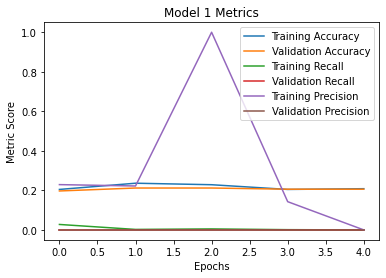

In [41]:
# Plot accuracy, recall, and precision
plt.plot(results.history['acc'], label='Training Accuracy')
plt.plot(results.history['val_acc'], label='Validation Accuracy')

plt.plot(results.history['recall'], label='Training Recall')
plt.plot(results.history['val_recall'], label='Validation Recall')

plt.plot(results.history['precision'], label='Training Precision')
plt.plot(results.history['val_precision'], label='Validation Precision')

plt.title('Model 1 Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Score')
plt.legend();

**Interpretation:** The 3 main metrics for this project include: accuracy, recall, and precision. These metrics have been plotted over numerous epochs.

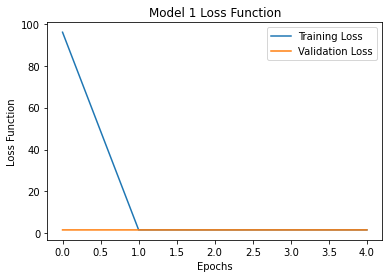

In [42]:
# Plot loss function
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')

plt.title('Model 1 Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend();

**Interpretation:** The loss function is plotted above. The ideal value for a loss function is 0.

In [45]:
# Referenced: https://git.generalassemb.ly/DSIR-Lancelot/8.02-lesson-tensorflow-keras/blob/master/starter-code-Adi-InClass.ipynb
# Visualize model layers
plot_model(model, show_layer_names=True, show_shapes=True)

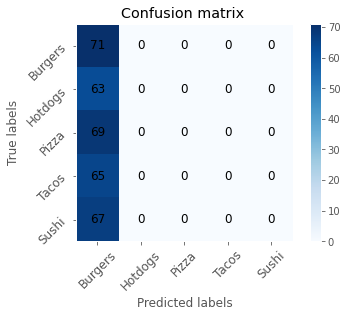

In [11]:
# Referenced: https://github.com/clairehester/face-mask-detector/blob/main/code/02_face_mask_detector.ipynb
preds = model.predict(X_test, batch_size=8)
preds = np.argmax(preds, axis=1)

cm = confusion_matrix(y_test.argmax(axis=1), preds)

plt.style.use('ggplot')
plt.imshow(cm, cmap=plt.cm.Viridis, interpolation='nearest')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(cm)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.yticks(np.arange(len(cm)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.title('Confusion matrix ')
plt.grid(None)
plt.colorbar()
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center', size='large')
plt.show()

In [ ]:
# Store predictions

### Model 3: ResNet50

In [ ]:
# Referenced: https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38

In [18]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

In [19]:
restnet = ResNet50(include_top=False, weights='imagenet',
                  input_shape=X_train[0].shape)
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)

restnet = Model(restnet.input, outputs=output)

for layer in restnet.layers:
    layer.trainable = False
    
# restnet.summary()

In [20]:
# Transfer Learning phase
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

In [21]:
res_model = Sequential()
res_model.add(restnet)
res_model.add(Dense(64, activation='relu', input_dim=X_train[0].shape))
res_model.add(Dropout(0.3))
res_model.add(Dense(64, activation='relu'))
res_model.add(Dropout(0.3))
res_model.add(Dense(5, activation='softmax'))

res_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizers.RMSprop(lr=2e-5),
                 metrics=['accuracy'])

res_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 100352)            23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 30,014,789
Trainable params: 6,427,077
Non-trainable params: 23,587,712
__________________________________

In [22]:
# res_results = res_model.fit(X_train, y_train, batch_size=8,
#                            epochs=3, validation_data=(X_test, y_test))

In [23]:
# Alternative fit model method with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, 
                                   rotation_range=50, width_shift_range=0.2,
                                  height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_test, y_test, batch_size=8)

res_results = res_model.fit_generator(train_generator,
                           epochs=50, validation_data=val_generator)

/Users/seungwoochoi/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
126/126 [==============================] - 258s 2s/step - loss: 1.7728 - accuracy: 0.1739 - val_loss: 1.6094 - val_accuracy: 0.1940
Epoch 2/50
126/126 [==============================] - 199s 2s/step - loss: 1.6094 - accuracy: 0.1907 - val_loss: 1.6094 - val_accuracy: 0.2119
Epoch 3/50
126/126 [==============================] - 257s 2s/step - loss: 1.6094 - accuracy: 0.2321 - val_loss: 1.6094 - val_accuracy: 0.2119
Epoch 4/50
126/126 [==============================] - 226s 2s/step - loss: 1.6094 - accuracy: 0.2186 - val_loss: 1.6094 - val_accuracy: 0.2119
Epoch 5/50
126/126 [==============================] - 176s 1s/step - loss: 1.6094 - accuracy: 0.2065 - val_loss: 1.6094 - val_accuracy: 0.2119
Epoch 6/50
126/126 [==============================] - 175s 1s/step - loss: 1.6094 - accuracy: 0.2260 - val_loss: 1.6094 - val_accuracy: 0.2119
Epoch 7/50
126/126 [==============================] - 182s 1s/step - loss: 1.6094 - accuracy: 0.2294 - val_loss: 1.6094 - val_accuracy: 0.2119

KeyboardInterrupt: 

#### Model 2: CNN pre-trained on EfficientNet

In [26]:
# Referenced: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb#scrollTo=G2iZMMXDMEb_
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [27]:
img_augmentation = Sequential([
    preprocessing.RandomRotation(factor=0.15),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    preprocessing.RandomFlip(),
    preprocessing.RandomContrast(factor=0.1),
    ],
    name='img_augmentation',
)

In [28]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0

In [34]:
# Attempt 2
inputs2 = layers.Input(shape=X_train[0].shape)
x2 = img_augmentation(inputs2)
new_model2 = EfficientNetB0(include_top=False, input_tensor=x2, weights='imagenet')

new_model2.trainable = False

x2 = layers.GlobalAveragePooling2D(name='avg_pool')(new_model2.output)
x2 = layers.BatchNormalization()(x2)

top_dropout_rate = 0.2
x2 = layers.Dropout(top_dropout_rate, name='top_dropout')(x2)
outputs2 = layers.Dense(5, activation='softmax', name='pred')(x2)

new_model2 = tf.keras.Model(inputs2, outputs2, name='EfficientNet')
optimizer2 = tf.keras.optimizers.Adam(learning_rate=1e-2)
new_model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

new_results2 = new_model2.fit(X_train, y_train, validation_data=(X_test, y_test),
                   batch_size=8, epochs=3)

Epoch 1/3
126/126 [==============================] - 165s 1s/step - loss: 6.5497 - accuracy: 0.2021 - val_loss: 1.6830 - val_accuracy: 0.2119
Epoch 2/3
126/126 [==============================] - 151s 1s/step - loss: 2.2781 - accuracy: 0.2026 - val_loss: 1.6798 - val_accuracy: 0.1881
Epoch 3/3
126/126 [==============================] - 168s 1s/step - loss: 2.0425 - accuracy: 0.2040 - val_loss: 1.7419 - val_accuracy: 0.2119


In [36]:
# Attempt 3
import efficientnet.keras as efn

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1.0/255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)
train_generator = train_datagen.flow_from_directory(X_train, batch_size = 20, class_mode='categorical', target_size = (224, 224))
validation_generator = test_datagen.flow_from_directory(X_test, batch_size = 20, class_mode='categorical', target_size = (224, 224))

base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
x = model1.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation="softmax")(x)
model_final = Model(input = model1.input, output = predictions)

model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

eff_history = model_final.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 3)

ValueError: listdir: embedded null character in path

In [37]:
# Classic, underfit neural network
inputs = layers.Input(shape=X_train[0].shape)
x = img_augmentation(inputs)
new_model = EfficientNetB0(include_top=False, input_tensor=x, weights='imagenet')

# new_model.trainable = False # Freeze the pretrained weights
for layer in new_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D(name='avg_pool')(new_model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name='top_dropout')(x)
outputs = layers.Dense(5, activation='softmax', name='pred')(x)

new_model = tf.keras.Model(inputs, outputs, name='EfficientNet')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

# Fit the model
new_results = new_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                   batch_size=8, epochs=3) # Change # of epochs to 50

Epoch 1/3
126/126 [==============================] - 116s 859ms/step - loss: 3.7092 - acc: 0.2002 - val_loss: 1.7081 - val_acc: 0.1940
Epoch 2/3
126/126 [==============================] - 130s 1s/step - loss: 2.7356 - acc: 0.1994 - val_loss: 1.7751 - val_acc: 0.2000
Epoch 3/3
126/126 [==============================] - 134s 1s/step - loss: 2.3771 - acc: 0.1870 - val_loss: 1.6426 - val_acc: 0.2060


In [30]:
# new_model.summary()

In [32]:
# Doesn't work - delete code
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    new_model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


### Post-Modeling

In [ ]:
# probas = np.array([[0.4, 0.1, 0.5],[0.7, 0.2, 0.1],[0.3, 0.4, 0.3]])
probas = model.predict(X_test)
labels = np.argmax(probas, axis=-1)    
print(labels)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
# Predictions
y_preds = model.predict(X_test)
y_preds.shape

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(model, y_preds, y_test)
# labels=['burger', 'hotdog', 'pizza', 'tacos', 'sushi']

In [ ]:
# Try 1-2 changes to hidden layers - look for improvements
# If yes, there were low hanging fruit worth my time
# If no, go collect more images (start with image augmentation in keras)
# Keras directory and my data setup should work perfectly

In [ ]:
# Use Google Colab to run this

In [ ]:
# Need more hidden layers/neurons

In [ ]:
# Precision/recall

In [ ]:
# Image Data Augmentation

In [ ]:
# Analysis of misclassifications

### Exploratory Data Analysis (EDA)

In [15]:
from PIL import Image

In [16]:
# Histogram of image dimensions
im = Image.open('../images/burgers/burgers_1.jpg')
im.size[0]

3024

In [17]:
def image_size_retriever(food_list, food_class):
    image_dict = {}
    file_path = f'../images/{food_class}'
    for file in os.listdir(file_path):
        try:
            image = Image.open(file_path + file)
            image_dict[image.size[0]] = image_dict[image.size[1]]
        except:
            print(f'Error for file: {file}')
    return image_dict

In [18]:
my_index = 0
for food_class in class_list:
    image_size_retriever(food_class, food_classes[my_index])
    my_index += 1

Error for file: burgers_15.jpg
Error for file: burgers_29.jpg
Error for file: burgers_198.jpg
Error for file: burgers_239.jpg
Error for file: burgers_211.jpg
Error for file: burgers_205.jpg
Error for file: burgers_204.jpg
Error for file: burgers_210.jpg
Error for file: burgers_238.jpg
Error for file: burgers_199.jpg
Error for file: burgers_28.jpg
Error for file: burgers_14.jpg
Error for file: burgers_14.png
Error for file: burgers_16.png
Error for file: burgers_206.jpg
Error for file: burgers_212.jpg
Error for file: burgers_213.jpg
Error for file: burgers_207.jpg
Error for file: burgers_17.png
Error for file: burgers_13.png
Error for file: burgers_13.jpg
Error for file: .DS_Store
Error for file: burgers_203.jpg
Error for file: burgers_217.jpg
Error for file: burgers_216.jpg
Error for file: burgers_202.jpg
Error for file: burgers_12.jpg
Error for file: burgers_12.png
Error for file: burgers_348.jpg
Error for file: burgers_38.jpg
Error for file: burgers_10.jpg
Error for file: burgers_214

In [ ]:
def image_converter(food_list, food_class):
    food_path = f'../images/{food_class}/'
    for file in os.listdir(food_path):
        try:
            image = load_img(food_path + file, target_size=(384, 384))
            image_arr = img_to_array(image) / 255
            food_list.append(image_arr)
        except:
            print(f'Error for file: {file}')
    print(f'{len(food_list)} pictures have been converted for {food_class}.')

In [ ]:
my_index = 0
for food_class in class_list:
    image_converter(food_class, food_classes[my_index])
    my_index += 1

In [ ]:
class_list = [burgers_list, hotdogs_list, pizza_list, tacos_list, sushi_list]

In [ ]:
food_classes = ['burgers', 'hotdogs', 'pizza', 'tacos', 'sushi']

In [ ]:
# Extra Code

In [ ]:
# Extra Model made from scratch
# # Referenced: https://git.generalassemb.ly/DSIR-Lancelot/8.04-lesson-cnns/blob/master/solution-code/02-cnn.ipynb
# # Model architecture
# model = Sequential([
#     Conv2D(32, kernel_size=(3,3), activation='relu', 
#            padding='same', input_shape=(X_train[0].shape)),
#     Conv2D(32, kernel_size=(3,3), activation='relu',
#           padding='same'),
#     MaxPooling2D(pool_size=(2,2), strides=2),
#     BatchNormalization(),
#     Conv2D(64, kernel_size=(3,3), activation='relu'),
#     Conv2D(64, kernel_size=(3,3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2,2), strides=2),
#     BatchNormalization(),
#     Flatten(),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     # Dropout layer
#     Dense(5, activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', 
#               metrics=['acc']) # 'Recall', 'Precision'

# # Fit the model
# results = model.fit(aug.flow(X_train, y_train, batch_size=8), validation_data=(X_test, y_test),
#                    batch_size=8,
#                     epochs=5) # Try 10 epochs